## To test sky subtraction using the mask from MTObjects
Things to try:
- sigma clipping on the sky pixels in the MTO mask
- fitting a plane to the sky pixels in the MTO mask


In [1]:
from glob import glob 
import pandas as pd
import numpy as np
import os, re, ast
from astropy.io import fits
from astropy.wcs import WCS
# from astropy import coordinates, units as u
import matplotlib.pyplot as plt
from photutils.isophote import EllipseGeometry

In [2]:
def plot_axes_in_degrees(ax):
    ra = ax.coords[0]
    dec = ax.coords[1]
    ra.set_major_formatter("d.ddd")
    dec.set_major_formatter("d.ddd")
    return None

def get_final_mask_data(obj_direc):
    list_of_files = glob(obj_direc + 'mask*.fits') # * means all if need specific format then *.csv
    final_mask_path = max(list_of_files, key=os.path.getctime)
    final_mask_data = fits.getdata(final_mask_path)
    return final_mask_data

def get_geometry_maxsma(obj_direc):
    if os.path.exists(obj_direc+"params.dat"):
        file = open(obj_direc+"params.dat", 'r').read()
        geom = ast.literal_eval(file)
        ellip_geometry = EllipseGeometry(x0=geom['x0'], y0=geom['y0'], sma=geom['sma'],\
                        eps=geom['eps'], pa=geom['pa']*np.pi/180.)
        return ellip_geometry, geom['maxsma']
    else:
        print("No input parameters file found!")
        return None, None
    

### Specify galaxy

In [3]:
mag_range = "15to16"
obj = "FDS7DWARF326"
fld, gal_id = re.findall(r'\d+', obj)

direc = "/home/srathi/data/SED/objects/{}/{}/".format(mag_range, obj)

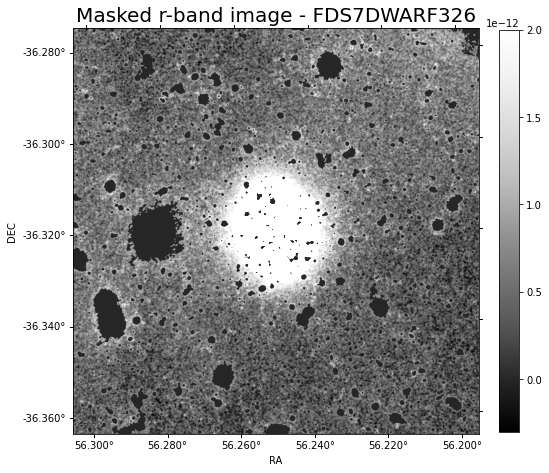

In [4]:
data, hdr = fits.getdata( direc + "rF{}D{}_final.fits".format(fld, gal_id), header=True)
wcs = WCS(hdr)

# final mask - assign values such that the sky pixels have value = 1 and objects have value = 0
mask_data = get_final_mask_data(direc)

# plotting
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=wcs)

# for adjusting the scale
cen_px = int(data.shape[0]/2)
cen_data = data[cen_px-25:cen_px+25, cen_px-25:cen_px+25]

im = ax.imshow(data*(1-mask_data), origin='lower', cmap="Greys_r", vmin=-3e-13, vmax=2e-12)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title("Masked r-band image - {}".format(obj), fontsize=20)
cb = plt.colorbar(im, ax=ax, fraction=0.045, pad=0.045)

plot_axes_in_degrees(ax)

### Estimating the sky-background 
- try image dilation (see `testing_dilation.ipynb`)
- Extract pixels that are marked as sky :
    - mask the pixels belonging to the galaxy 
        -  Galaxies for which an optimal mask as well as maxsma is available, all pixels falling in an elliptical aperture at the center of the image is used to mark the galaxy pixels - thus marking them different from the sky pixels
        - Galaxies for which photometry will be added, the sky background can be estimated at each iteration, but need to figure out how to mask galaxy pixels
- multiply the mask (with masked objects (incl. galaxy) = 0, sky pixels = 1) with the science image to put the object pixels to 0 
- get the median of the remaining pixels with non zero values

In [5]:
def elliptical_mask(data, geometry, maxsma):
    '''
    ----------------------------------------------------------------------
    Function to create elliptical mask at the center of the galaxy, given
    the primary matrix, geometry of ellipse and the maxsma of the ellipse
    ----------------------------------------------------------------------
    Returns: a boolean array with elements belonging to ellipse as True
    ----------------------------------------------------------------------
    '''
    from skimage.draw import ellipse
    cen_px = int(np.ceil(data.shape[0]/2))
    maxsma = int(np.ceil(maxsma))
    pa = geometry.pa
    if pa > np.pi:
        pa =- np.pi
    elif pa < -np.pi:
        pa += np.pi
    rr, cc = ellipse(cen_px, cen_px, maxsma*(1-geometry.eps), maxsma, rotation=pa+np.pi/2)
    img = np.ones(data.shape, dtype=np.uint8)
    img[rr, cc] = 0
    img = img.T
    
    return img==0
    

In [6]:
# load geometry and maxsma
geometry, maxsma = get_geometry_maxsma(direc)

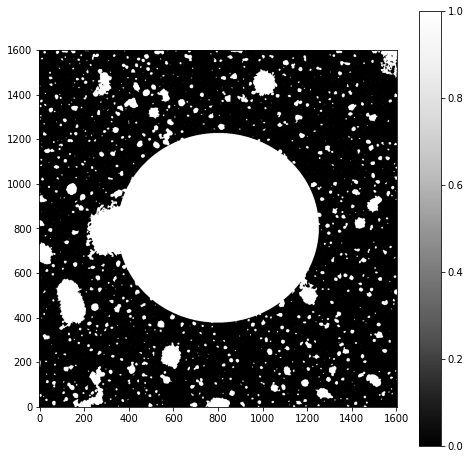

In [7]:
mask_w_gal = mask_data.copy()
ellip_mask = elliptical_mask(mask_w_gal, geometry, maxsma)

mask_w_gal[ellip_mask] = 1

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(mask_w_gal, origin='lower', cmap='Greys_r');
cb = plt.colorbar(im, ax=ax)

In [8]:
sky = data[mask_w_gal==0]
sky.flatten();

5.1059515e-13 4.9350666e-13 2.7841355e-13


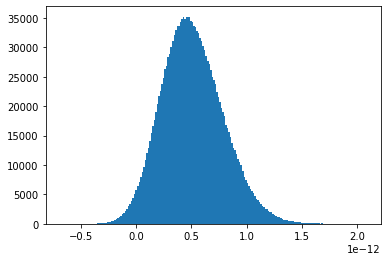

In [9]:
## iske baad use numpy masked array to mask all the pixels with value = 0
# hist, _ = np.histogram(mask_w_gal[mask_w_gal!=0], bins=20)
plt.hist(sky, bins=200);
print(np.mean(sky), np.median(sky), np.std(sky))

In [10]:
from astropy.stats import sigma_clipped_stats

mean, bkg, std = sigma_clipped_stats(data, sigma=3.0)
print(mean, bkg, std)

6.397852e-13 5.6562047e-13 4.139113e-13


### Fitting a plane to the sky pixels (astropy's example)

Text(0.5, 1.0, 'Residual')

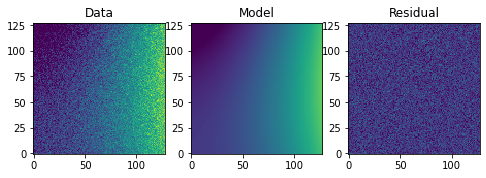

In [13]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Generate fake data
np.random.seed(0)
y, x = np.mgrid[:128, :128]
z = 2. * x ** 2 - 0.5 * x*y + 1.5 * x * y - y**2 - 1.
z += np.random.normal(0., 0.1, z.shape) * 50000.

# mask some data


# Fit the data using astropy.modeling
p_init = models.Polynomial2D(degree=2)
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest', vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Residual")